In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

In [2]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_mean_contour(node_x, node_y, mean_SI):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    
    from scipy.interpolate import griddata
    SI = griddata((node_x, node_y), mean_SI, (xgrid, ygrid), method='nearest', fill_value=np.nan)
    return SI


def get_T(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, T

def get_U(node_x, node_y, data_file):
    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        #T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, U


def get_V(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        #T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, V

In [4]:
cases = [2.9,
]

data_folders = [
    "/Volumes/ThermalAmp/Tr2.9/"
]

In [5]:

from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning

for i, data_folder in enumerate(data_folders):
    
    case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    case_files = [f for f in case_files if "/._" not in f]
    
    fname = os.path.join(data_folder, case_files[0])
    
    # Read the mesh data from the HDF5 file
    with h5py.File(fname, 'r') as f:
        vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
    
    # Extract NodeX and NodeY
    node_x = vertex_list[0]
    node_y = vertex_list[1]

    # Define constants
    tw = 308
    yw = -0.015
    ta = 298
    
    # Find *dat.post files
    data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
    data_files = [f for f in data_files if "/._" not in f]
    
    def get_time(data_file):
        try:
            return float(data_file.split(".")[0].split("-")[-1])  #My directories
            #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
        except:
            return float(data_file.split(".")[1].split("-")[-1])
    
    data_files = sorted(data_files, key=get_time)
    print(len(data_files))

    if "10000.dat.post" in data_files[3999]:
        dats = data_files[3999:-1001]
    else:
        dats = data_files[0:10000]

    # Use LokyBackend tso protect the h5py routine
    SIs = Parallel(n_jobs=-1, backend='threading', verbose=1) \
    (delayed(get_T) \
     (node_x, node_y, data_file
     ) for data_file in dats)
    SIs_dat = np.array(SIs, dtype=object)
    all_Ts_array = np.vstack(SIs_dat[:,2])
    # Check the shape to ensure it is (500, 235616)
    print(all_Ts_array.shape)  # Should output (500, 235616)
    # Calculate the timewise mean for each of the 235616 elements
    timewise_mean = np.nanmean(all_Ts_array, axis=0)
    SI = get_mean_contour(node_x, node_y, timewise_mean)
    with h5py.File('/Volumes/ThermalAmp/NewAverageContours/T/Tr{}.h5'.format(cases[i]), 'w') as f:
        f.create_dataset('T', data=SI)
        f.create_dataset('node_x', data=xgrid)
        f.create_dataset('node_y', data=ygrid)
    del SIs, SIs_dat, all_Ts_array, SI, timewise_mean 
      

    """
    # Use LokyBackend tso protect the h5py routine
    SIs = Parallel(n_jobs=-1, backend='threading', verbose=1) \
    (delayed(get_U) \
     (node_x, node_y, data_file
     ) for data_file in dats)
    SIs_dat = np.array(SIs, dtype=object)
    all_Ts_array = np.vstack(SIs_dat[:,2])
    # Check the shape to ensure it is (500, 235616)
    print(all_Ts_array.shape)  # Should output (500, 235616)
    # Calculate the timewise mean for each of the 235616 elements
    timewise_mean = np.nanmean(all_Ts_array, axis=0)
    SI = get_mean_contour(node_x, node_y, timewise_mean)
    with h5py.File('/Volumes/ThermalAmp/NewAverageContours/U/Tr{}.h5'.format(cases[i]), 'w') as f:
        f.create_dataset('T', data=SI)
        f.create_dataset('node_x', data=xgrid)
        f.create_dataset('node_y', data=ygrid)
    del SIs, SIs_dat, all_Ts_array, SI, timewise_mean 

    # Use LokyBackend tso protect the h5py routine
    SIs = Parallel(n_jobs=-1, backend='threading', verbose=1) \
    (delayed(get_V) \
     (node_x, node_y, data_file
     ) for data_file in dats)
    SIs_dat = np.array(SIs, dtype=object)
    all_Ts_array = np.vstack(SIs_dat[:,2])
    # Check the shape to ensure it is (500, 235616)
    print(all_Ts_array.shape)  # Should output (500, 235616)
    # Calculate the timewise mean for each of the 235616 elements
    timewise_mean = np.nanmean(all_Ts_array, axis=0)
    SI = get_mean_contour(node_x, node_y, timewise_mean)
    with h5py.File('/Volumes/ThermalAmp/NewAverageContours/V/Tr{}.h5'.format(cases[i]), 'w') as f:
        f.create_dataset('T', data=SI)
        f.create_dataset('node_x', data=xgrid)
        f.create_dataset('node_y', data=ygrid)
    del SIs, SIs_dat, all_Ts_array, SI, timewise_mean 
    """


env: PYTHONWARNINGS=ignore::UserWarning
10000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 10000 out of

(10000, 235616)


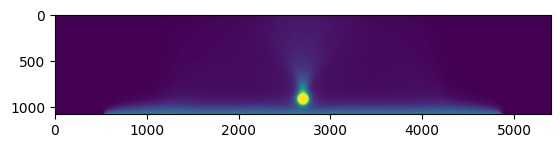

In [9]:
with h5py.File("/Volumes/ThermalAmp/NewAverageContours/T/Tr2.3.h5", 'r') as f:
    SI = f['T'][:]
plt.imshow(SI)


In [13]:
with h5py.File('/Volumes/ThermalAmp/NewAverageContours/U/Tr{}.h5'.format(cases[0]), 'w') as f:
        f.create_dataset('T', data=SI)
        f.create_dataset('node_x', data=xgrid)
        f.create_dataset('node_y', data=ygrid)
del SIs, SIs_dat, all_Ts_array, SI, timewise_mean 